## Bayesian Methods for Hackers, chaper 1
### Text messages data

### Gather data

In [1]:
url = "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv"
run(`wget $url -O txtdata.csv`)

--2022-10-16 18:41:02--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1850 (1.8K) [text/plain]
Saving to: ‘txtdata.csv’

     0K .                                                     100% 1016K=0.002s

2022-10-16 18:41:02 (1016 KB/s) - ‘txtdata.csv’ saved [1850/1850]



Process(`wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv -O txtdata.csv`, ProcessExited(0))

### Data exploration

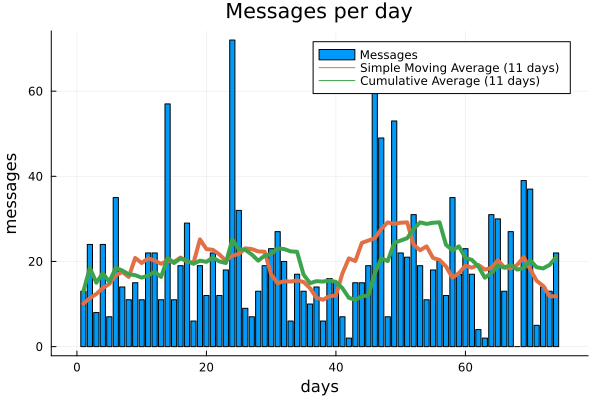

In [2]:
using CSV
using DataFrames
using Statistics
using Plots

function load()
    df = CSV.read("./txtdata.csv", DataFrame, header = ["messages"])
    messages = Integer.(vec(df.messages))
    return messages
end

# SMA for 2*n+1 days around each datapoint
sma2Np1(v, n) = [@views sum(v[max(1, i-n):min(size(v, 1), i+n)]) / (2 * n + 1) for i in 1:size(v, 1)]
cumulative_average(v, n) = [@views sum(v[max(1, i-n):i]) / (i - max(1, i-n) + 1) for i in 1:size(v, 1)]

function visualize(messages)
    days = 1:size(messages, 1)
    p = bar(days, messages, 
        title = "Messages per day", 
        label = "Messages",
        xlabel = "days", 
        ylabel = "messages"
    )

    n = 5; t = 2 * n + 1;
    plot!(p, days, sma2Np1(messages, n), label = "Simple Moving Average ($t days)", lw=4)
    plot!(p, days, cumulative_average(messages, 2 * n), label = "Cumulative Average ($t days)", lw=4)
    
    return p
end

messages = load()
visualize(messages)

### Probabilistic model

In [3]:
using Gen

@gen function model(
        messages, 
        τ_distribution = uniform_discrete, 
        λ_distribution = exponential,
        count_distribution = poisson
    )
    days = size(messages, 1)
    α = 1 / mean(messages)
    
    τ ~ τ_distribution(1, days)
    λ1 ~ λ_distribution(α)
    λ2 ~ λ_distribution(α)
    
    return [{:count => i} ~ count_distribution(i <= τ ? λ1 : λ2) for i in 1: days]
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, Some(Gen.UniformDiscrete()), Some(Gen.Exponential()), Some(Gen.Poisson())], var"##model#292", Bool[0, 0, 0, 0], false)

### Explore the model

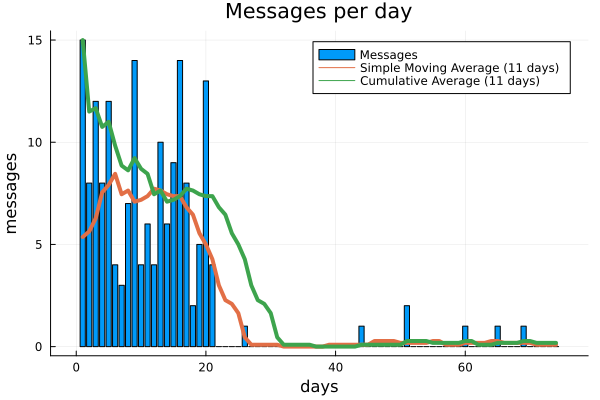

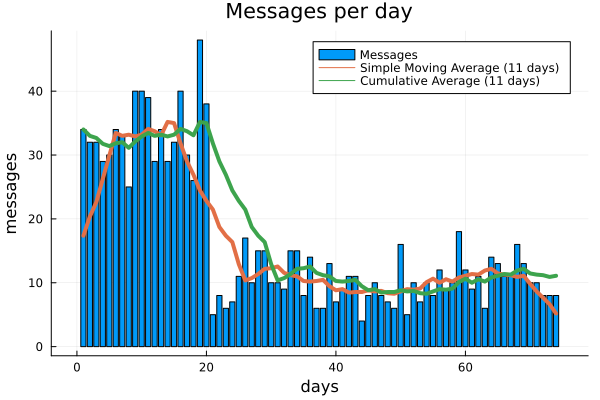

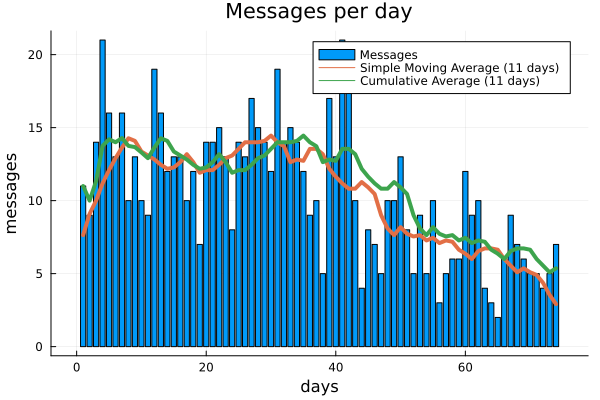

In [4]:
sample(model) = Gen.simulate(model, (messages, ))

for _ in 1:3
    display(visualize(get_retval(sample(model))))
end

### Fit the model to data

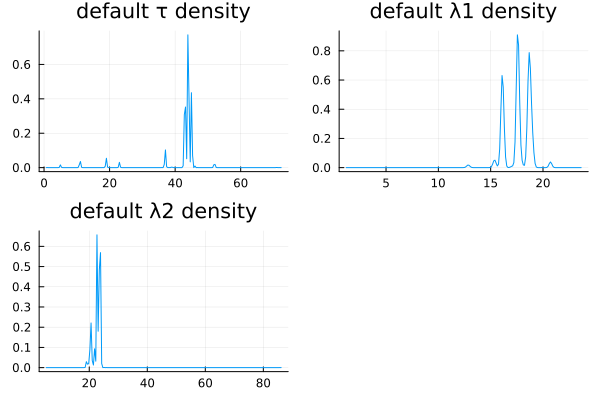

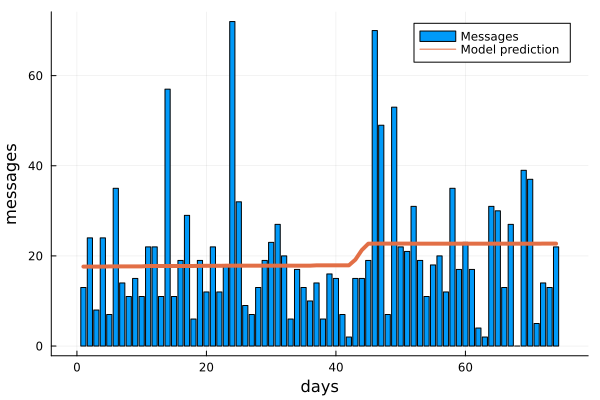

In [19]:
using StatsPlots
using LinearAlgebra

function fit(model, messages, iterations, args = ())
    constraints = choicemap()
    for (day, count) in enumerate(messages)
        constraints[:count => day] = count
    end
    
    (trace, _) = generate(model, (messages, args...), constraints)
    
    params = []
    for iter=1:iterations
        (trace, _) = metropolis_hastings(trace, Gen.select(:τ, :λ1, :λ2))
        push!(params, (trace[:τ], trace[:λ1], trace[:λ2]))
    end
    
    params
end

# used as reference:
# https://github.com/Tuebel/BayesianMethodsForHackers/blob/main/BayesianMethodsGen/Chapter1_gen.ipynb

function visualize_params(messages, params, prefix = "")
    τs = map(x -> x[1], params)
    λ1s = map(x -> x[2], params)
    λ2s = map(x -> x[3], params)
    
    display(plot(
            [density(data, legend=false) for data in [τs, λ1s, λ2s]]..., 
            title = ["$prefix τ density" "$prefix λ1 density" "$prefix λ2 density"]
    ))
    
    expected = []
    for day = eachindex(messages)
        ix = [day < τ for τ in τs]
        push!(expected, (sum(ix ⋅ λ1s) + sum(.!ix ⋅ λ2s)) / length(ix))
    end
    
    g = bar(messages, xlabel="days", ylabel="messages", label="Messages")
    plot!(g, expected, label="Model prediction", linewidth=4)
    display(g)
end

function fit_and_visualize(name, model, messages, iterations, args = ())
   params = fit(model, messages, iterations)
    visualize_params(messages, params, name) 
end

fit_and_visualize("default", model, messages, 30_000)

### Explore model variations

model - (Gen.UniformDiscrete(), Gen.Normal(), Gen.Poisson())


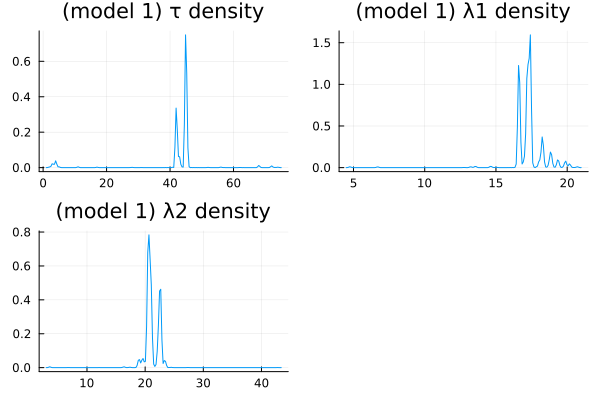

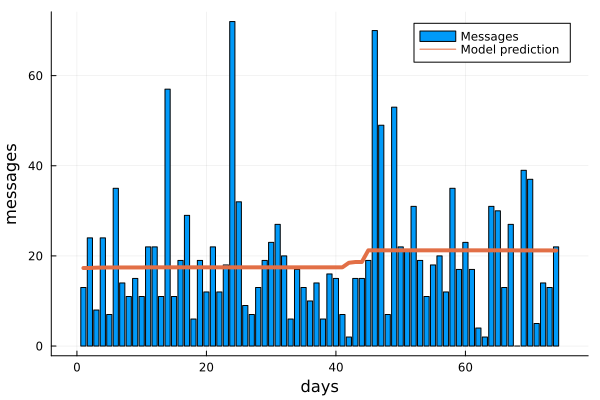

model - (Gen.UniformDiscrete(), Gen.Geometric(), Gen.Poisson())


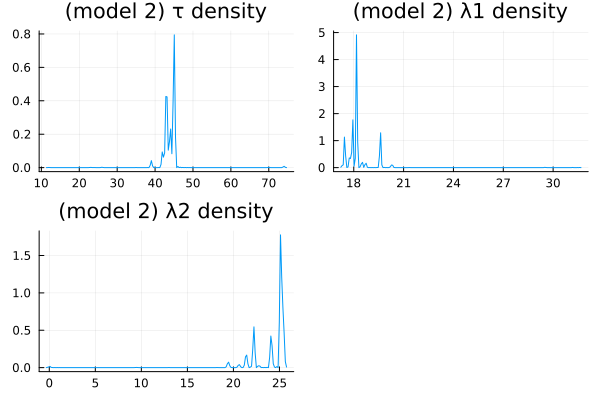

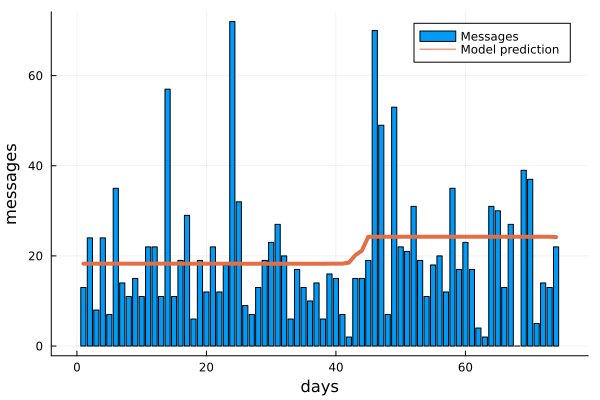

model - (Gen.UniformDiscrete(), Gen.InverseGamma(), Gen.Poisson())


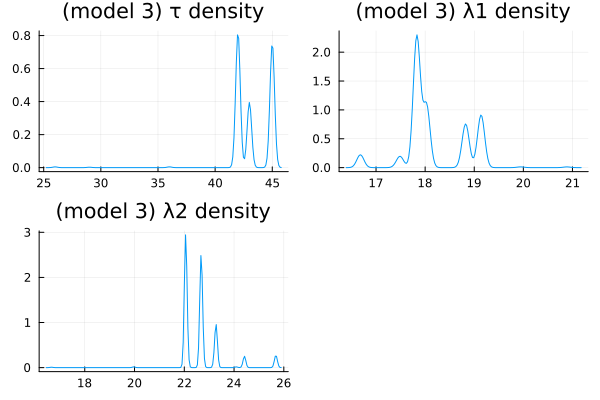

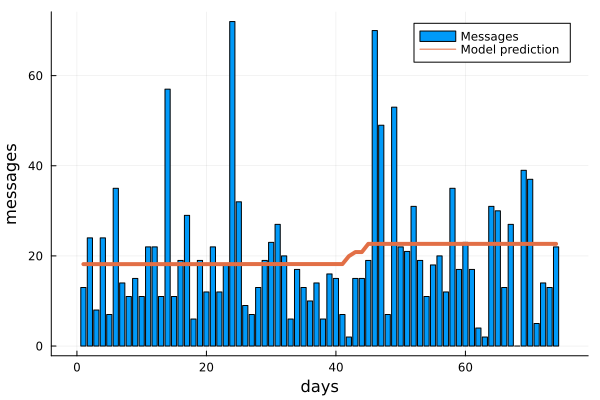

model - (Gen.UniformDiscrete(), Gen.UniformContinuous(), Gen.Poisson())


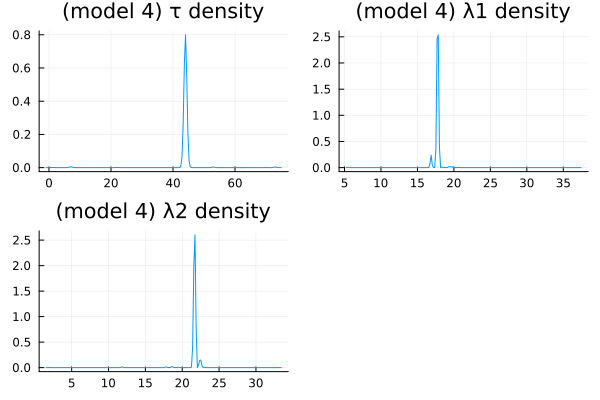

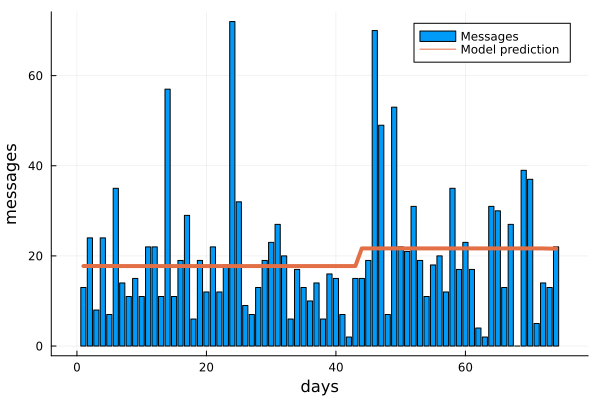

model - (Gen.UniformDiscrete(), Gen.Exponential(), Gen.UniformDiscrete())


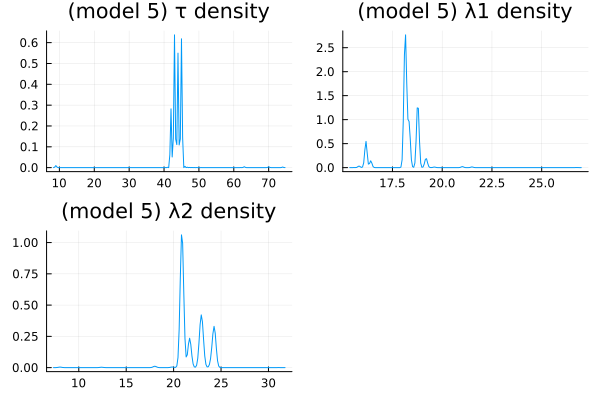

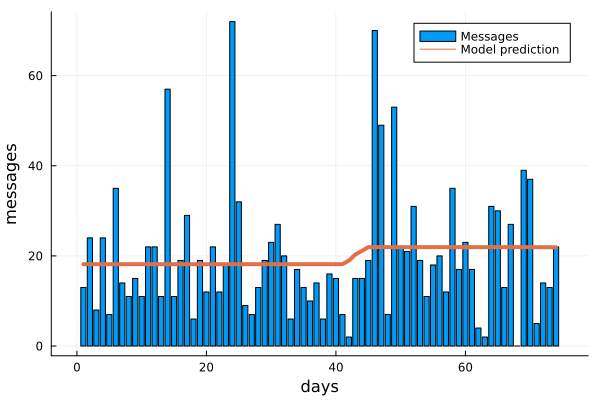

model - (Gen.UniformDiscrete(), Gen.Exponential(), Gen.UniformDiscrete())


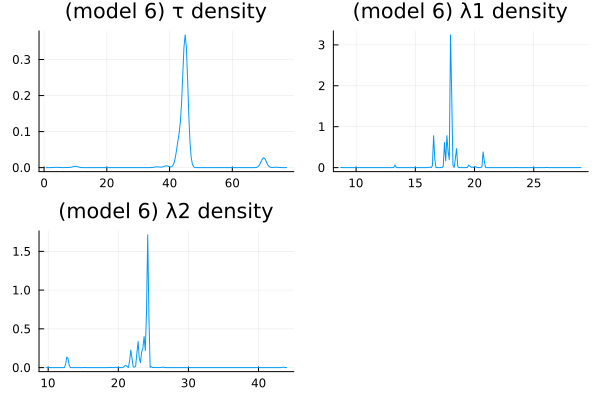

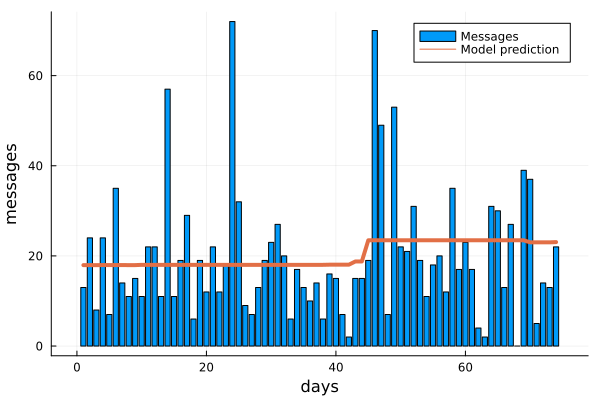

model - (Gen.UniformDiscrete(), Gen.Exponential(), Gen.UniformDiscrete())


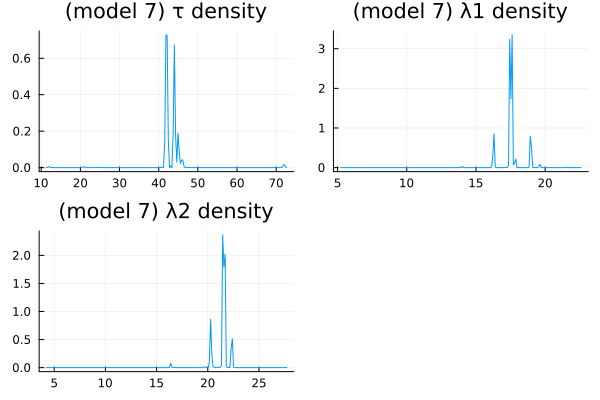

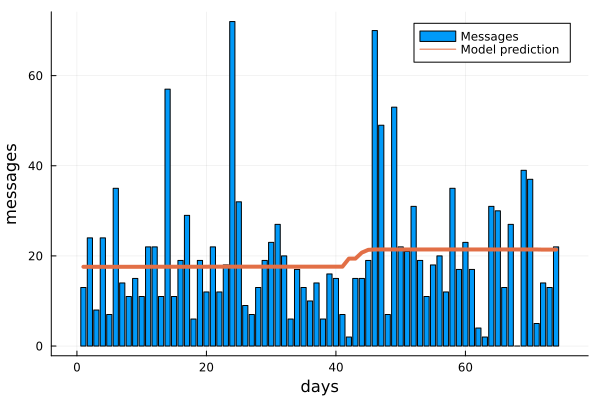

model - (Gen.UniformDiscrete(), Gen.Exponential(), Gen.UniformDiscrete())


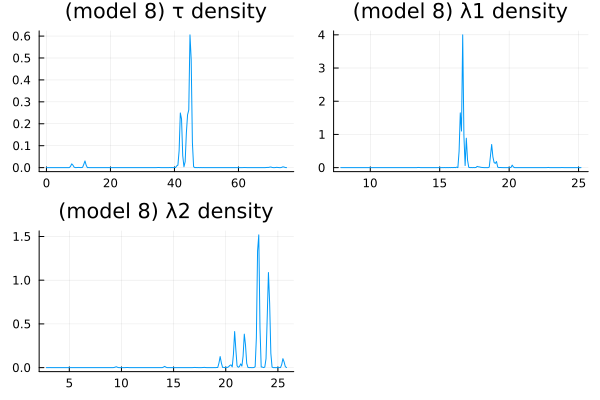

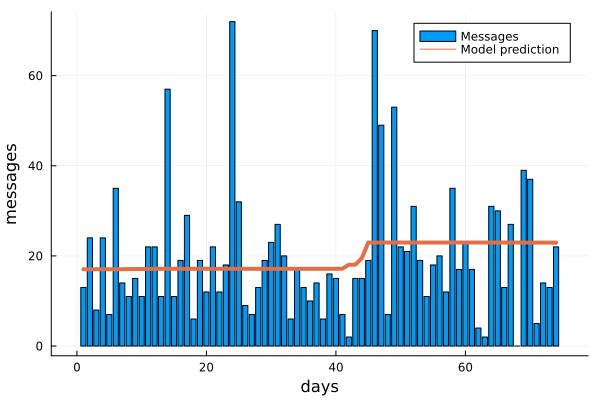

In [20]:
models_args = [
    # τ - λ1 - λ2 assumed distributions
    (uniform_discrete, normal, poisson),
    (uniform_discrete, geometric, poisson),
    (uniform_discrete, inv_gamma, poisson),
    (uniform_discrete, uniform, poisson),
    
    (uniform_discrete, exponential, uniform_discrete),
    (uniform_discrete, exponential, uniform_discrete),
    (uniform_discrete, exponential, uniform_discrete),
    (uniform_discrete, exponential, uniform_discrete),
]

for (i, args) in enumerate(models_args)
    println("model - $args")
    fit_and_visualize("(model $i)", model, messages, 30_000, args)
end